In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

In [2]:
CAMVID_PATH = Path('/home/wesley/Documents/Code/SegNet-Tutorial/CamVid/')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [3]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    #joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

In [5]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 2
torch.cuda.manual_seed(0)

In [6]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

/home/wesley/anaconda3/envs/segment/lib/python3.6/site-packages/torch/nn/modules/loss.py:206: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [7]:
state_dict = torch.load('weights/checkpoint-600.pt')
model.load_state_dict(state_dict['state_dict'])
optimizer.load_state_dict(state_dict['optimizer'])

In [8]:
train_utils.test(model, test_loader, criterion, epoch=1)  

/home/wesley/Documents/Code/pytorch_tiramisu/utils/training.py:91: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data.cuda(), volatile=True)


(0.5407622937972729, 0.1651791452991453)

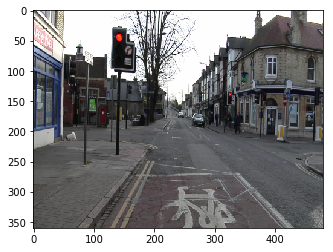

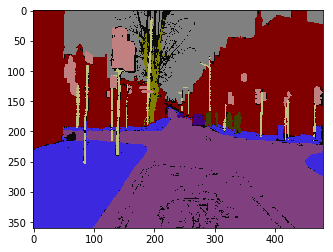

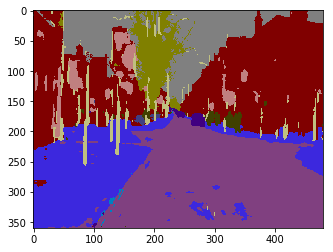

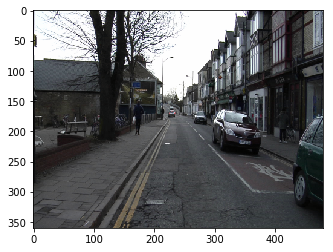

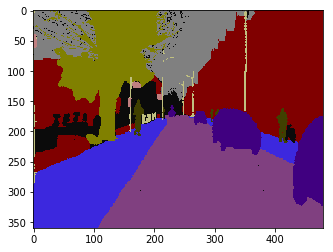

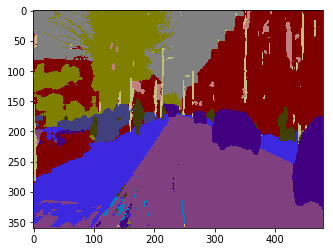

In [10]:
train_utils.view_sample_predictions(model, test_loader, n=3)